In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def runge_kutta_matrix(ode_fun, t_final, t_initial, y_terminal, n):
    """
    Solve a matrix ODE using 4th order Runge-Kutta method, working backwards.

    Parameters
    ----------
    ode_fun : callable
        Function to compute the ODE derivatives, with signature
        ode_fun(t: float, y: np.ndarray) -> np.ndarray, where y is M x N matrix.
    t_final : float
        Final time.
    t_initial : float
        Initial time.
    y_terminal : np.ndarray, shape (M, N)
        Terminal conditions as a 2D numpy array.
    n : int
        Number of time steps to divide the interval [t_initial, t_final] into.

    Returns
    -------
    t : np.ndarray, shape (n+1,)
        1D numpy array with linearly spaced values from t_initial to t_final.
    y : np.ndarray, shape (n+1, M, N)
        3D numpy array where the ODE solution is stored for each time step.

    """
    # Generate linearly spaced values from t_final to t_initial
    t = np.linspace(t_final, t_initial, n+1)
    # Calculate negative step size
    h = -(t_final - t_initial) / n
    
    # Create numpy array y with the same shape as y_terminal
    M, N = y_terminal.shape
    y = np.zeros((n+1, M, N))
    # Set terminal conditions as the first element of y
    y[0, :, :] = y_terminal
    
    # Iterate through time steps
    for i in range(n):
        # Calculate intermediate values k1, k2, k3, and k4
        k1 = h * ode_fun(t[i], y[i, :, :])
        k2 = h * ode_fun(t[i] - h/2, y[i, :, :] + k1/2)
        k3 = h * ode_fun(t[i] - h/2, y[i, :, :] + k2/2)
        k4 = h * ode_fun(t[i] - h, y[i, :, :] + k3)
        
        # Update y at next time step
        y[i+1, :, :] = y[i, :, :] + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    # Return flipped t and y arrays (ascending order of time)
    return np.flip(t), np.flip(y, axis=0)

In [25]:
A = np.array([[0.5, 3.0], [3.0, 0.5]])
B = np.array([[0.5, 3.0], [3.0, 0.5]])
C = np.array([[0.5, 3.0], [3.0, 0.5]])
D = np.array([[0.5, 3.0], [3.0, 0.5]])
A_T = np.transpose(A)
B_T = np.transpose(B)
C_T = np.transpose(C)
D_T = np.transpose(D)
Q = np.array([[1.0, 2.0], [2.0, 1.0]])
R = np.array([[1.0, 3.0], [3.0, 1.0]])
S = np.array([[2.0, 3.0], [3.0, 2.0]])
S_T = np.transpose(S)

QSSR = np.concatenate((np.concatenate((Q, S.T), axis=1), np.concatenate((S, R), axis=1)), axis=0)

# compute the inverse of result
QSSR_inv = np.linalg.inv(QSSR)

# extract the submatrices
Q_tilde = QSSR_inv[:2, :2]
S_tilde = QSSR_inv[:2, 2:]
R_tilde = QSSR_inv[2:, 2:]



# Terminal conditions
G = np.array([[3.8, 4.2], [4.2, 3.8]])
y_primal_terminal = - G
y_dual_terminal = - np.linalg.inv(G)

print(A_T, B_T, C_T, D_T)


[[0.5 3. ]
 [3.  0.5]] [[0.5 3. ]
 [3.  0.5]] [[0.5 3. ]
 [3.  0.5]] [[0.5 3. ]
 [3.  0.5]]


In [26]:
def P_RHS(t, y):

    theta = np.linalg.inv(D_T @ y @ D - R) @ (S - B_T @ y - D_T @ y @ C)

    dydt = Q + theta.T @ S + S_T @ theta + theta.T @ R @ theta -  A_T @ y - y.T @ A - theta.T @ B_T @ y.T - y @ B @ theta\
         - (C_T + theta.T @ D_T) @ y @ (C + D @ theta)


    return dydt

def P_tilde_RHS(t, y):

    mu = (y - D @ S_tilde) @ np.linalg.inv(Q_tilde) @ np.transpose(S_tilde) @ D_T + D @ R_tilde @ D_T
    theta_1 = np.linalg.inv(mu) @ ((y - D @ S_tilde) @ np.linalg.inv(Q_tilde) @ (y - S_tilde.T @ B_T) - D @ R_tilde @ B_T - C @ y)
    theta = np.linalg.inv(Q_tilde) @ (y - S_tilde.T @ B_T - S_tilde.T @ D_T @ theta_1)
    theta_1_T = theta_1.T
    theta_T = theta.T
    dydt = - 2 * theta_T @ y + 2 * A * y + 2 * theta_1_T @ C @ y - theta_1_T @ y @ theta_1 + theta_T @ Q_tilde @ theta + (B + theta_1_T @ D) @ R_tilde @ (B_T + D_T @ theta_1)
    return dydt

def P_tilde_RHS_no_S(t, y):
    
    theta = np.linalg.inv(Q_tilde) @ y
    theta_T = np.transpose(theta)
    theta_1 = np.linalg.inv(y - D(t) @ R_tilde @ D(t).T) @ (C(t) @ y + D(t) @ R_tilde @ B(t).T)
    theta_1_T = np.transpose(theta_1)

    dydt = -y.T @ theta - theta_T @ y + y @ A(t).T + A(t) @ y.T + y.T @ C(t).T @ theta_1 + theta_1_T @ C(t) @ y - theta_1_T @ y @ theta_1\
          + theta_T @ Q_tilde @ theta + (B(t) + theta_1_T @ D(t)) @ R_tilde @ (B(t).T + D(t).T @ theta_1)
    return dydt

def M_RHS(t, y):

    t_dummy, P = runge_kutta_matrix(ode_fun=P_RHS,
                                    t_final=1,
                                    t_initial=0,
                                    y_terminal=y_primal_terminal,
                                    n=100)
    
    p = P
    kappa = - np.linalg.inv(D(t).T @ p @ D(t) + R) @ B(t).T @ y
    theta = np.linalg.inv(D(t).T @ p @ D(t) - R) @ (S - B(t).T @ p - D(t).T @ p @ C(t))

    dydt = - A(t).T @ y - p @ B(t) @ kappa - theta.T @ B(t).T @ y - (C(t).T + theta.T @ D(t).T) @ p @ D(t) @ kappa\
           + S.T @ kappa + theta.T @ R @ kappa
    
    return dydt

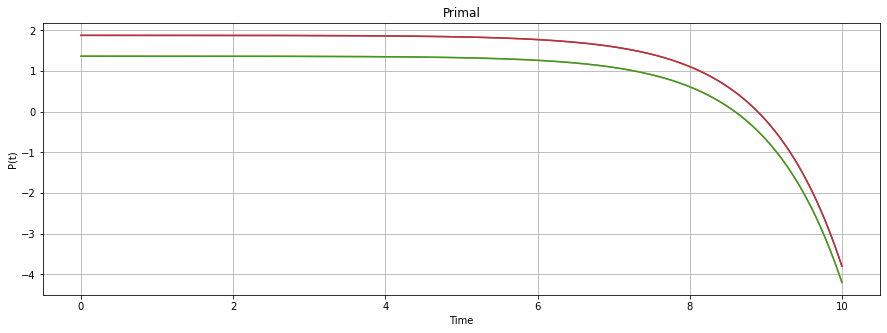

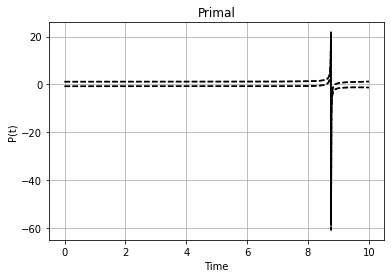

TypeError: 'numpy.ndarray' object is not callable

In [30]:
n = 1000
t_final = 10
t_initial = 0.0


t_primal, y_primal = runge_kutta_matrix(ode_fun=P_RHS,
                                        t_final=t_final,
                                        t_initial=t_initial,
                                        y_terminal=y_primal_terminal,
                                        n=n)

y_inv = np.zeros_like(y_primal)

for i in range(y_primal.shape[0]):
    y_inv[i] = np.linalg.inv(y_primal[i])

plt.figure(figsize=(15, 5))
plt.plot(t_primal, np.reshape(y_primal, (n+1, 4)))
plt.xlabel("Time")
plt.ylabel("P(t)")
plt.title("Primal")
plt.grid()
plt.show()
plt.plot(t_primal, np.reshape(y_inv, (n+1, 4)), 'k--')
plt.xlabel("Time")
plt.ylabel("P(t)")
plt.title("Primal")
plt.grid()
plt.show()


t_dual, y_dual = runge_kutta_matrix(P_tilde_RHS_no_S, 
                                    t_final=t_final, 
                                    t_initial=t_initial, 
                                    y_terminal=y_dual_terminal, 
                                    n=n)

plt.figure(figsize=(15, 5))
plt.plot(t_dual, np.reshape(y_dual, (n+1, 4)), 'o')
plt.plot(t_primal, np.reshape(y_inv, (n+1, 4)), 'k--')
plt.xlabel("Time")
plt.ylabel("P(t)")
plt.title("Dual")
plt.grid()
plt.show()


In [28]:
t_primal_M, y_primal_M = runge_kutta_matrix(ode_fun=M_RHS,
                                            t_final=1,
                                            t_initial=0,
                                            y_terminal=y_primal_terminal,
                                            n=n)


TypeError: 'numpy.ndarray' object is not callable